# [LAS model] : Listen, Attend and Spell
https://arxiv.org/abs/1508.01211
## Hello!😊
## This notebook is about LAS model that remarkable initial model of end to end ASR task.
## this model is not SOTA model these days but it is remarkable model that start end to end deep learning model for ASR task.
## specAugment paper is based on LAS model and authors reach SOTA result when they publish a paper.
## plus, this model looks like seq2seq!

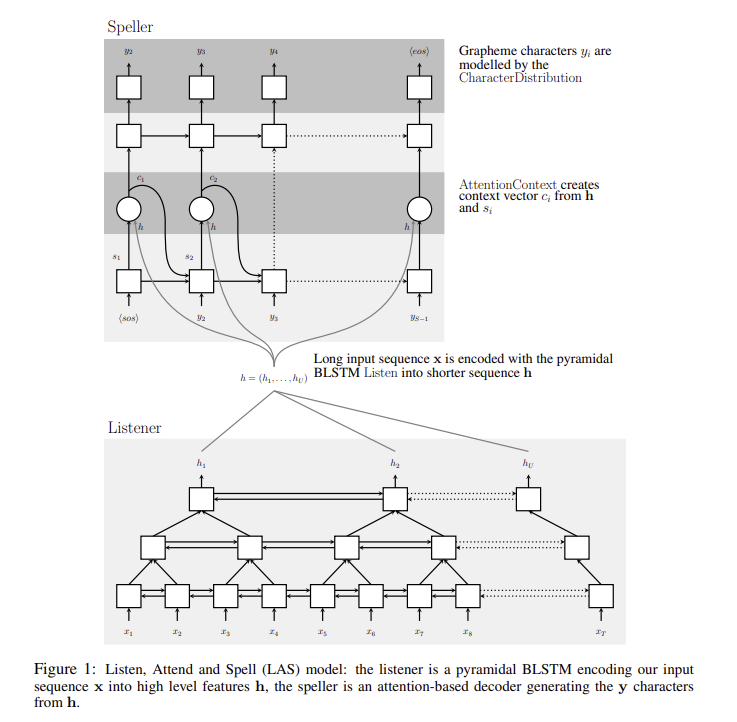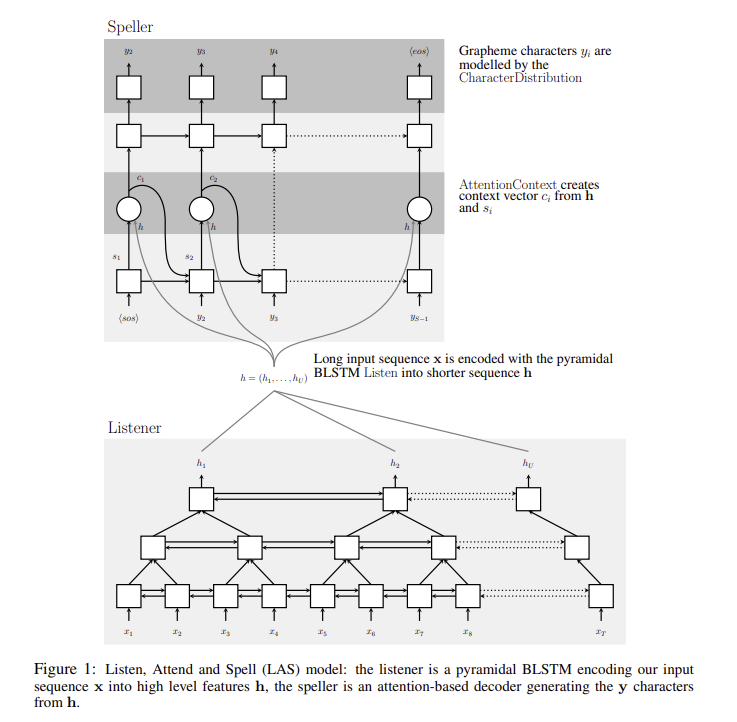

In [1]:
 !pip install torchmetrics

# Import Libraries

In [2]:
import os
import torch
import librosa
import torchaudio
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torchmetrics

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Configuration

In [4]:
class CFG:
    sr=16000
    n_fft=1024
    hop_length=512
    n_mels=100
    num_output=50
    max_length = 500
    
    batch_size = 4 #16
    worker = os.cpu_count()        #16
    num_channels = 100 #80
    
    dataset_list = ["dev-clean", "dev-other", "test-clean", "test-other", 
                    "train-clean-100","train-clean-360", "train-other-500"]
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
char_list = ['<pad>', '<sos>', '<eos>', '<unk>', " ", "A", "B", "C", "D", "E", "F", "G","H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "'"]
char2id = {v:k for k,v in enumerate(char_list)}
id2char = {k:v for k,v in enumerate(char_list)}

In [6]:
PAD_TOKEN = int(char2id['<pad>'])
SOS_TOKEN = int(char2id['<sos>'])
EOS_TOKEN = int(char2id['<eos>'])
UNK_TOKEN = int(char2id['<unk>'])

# Bi-LSTM & PYRAMID Bi-LSTM

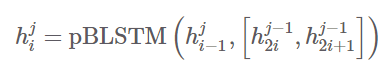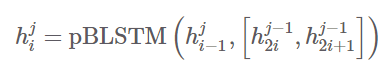

In [7]:
class BLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.0, n_layers=1, bidirectional=True):
        super(BLSTM, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        
        self.rnn = nn.LSTM(
            input_size=self.input_dim << 1,
            hidden_size=self.hidden_dim,
            num_layers=self.n_layers,
            bidirectional = self.bidirectional,
            dropout=dropout,
            batch_first=True
        )

    def forward(self, inputs):
        if isinstance(inputs, tuple):
            inputs, hc = inputs
        
        batch_size = inputs.size(0)
        seq_len = inputs.size(1)
        input_size = inputs.size(2)
        
        if seq_len % 2:
            zeros = torch.zeros((inputs.size(0), 1, inputs.size(2))).to(device)
            inputs = torch.cat([inputs, zeros], dim = 1)
            seq_len += 1
        inputs = inputs.contiguous().view(batch_size, int(seq_len / 2), input_size * 2)
        
        output, hc = self.rnn(inputs, hc)
        return (output, hc)

class Listener(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.0, n_layers=1, bidirectional=True):
        super(Listener, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = True
        
        self.pblstm = nn.Sequential(
            BLSTM(
                input_dim=self.input_dim,
                hidden_dim=self.hidden_dim,
                dropout=dropout,
                n_layers=n_layers,
                bidirectional = self.bidirectional
            ),
            BLSTM(
                input_dim=self.hidden_dim << 1 if self.bidirectional else 0,
                hidden_dim=self.hidden_dim,
                dropout=dropout,
                n_layers=n_layers,
                bidirectional = self.bidirectional
            ),
            BLSTM(
                input_dim=self.hidden_dim << 1 if self.bidirectional else 0,
                hidden_dim=self.hidden_dim,
                dropout=dropout,
                n_layers=n_layers,
                bidirectional = self.bidirectional
            ))
    
    def init_hidden(self, batch_size):
        hidden = Variable(torch.zeros(self.n_layers * 2 if self.bidirectional else 1, batch_size, self.hidden_dim))
        cell = Variable(torch.zeros(self.n_layers * 2 if self.bidirectional else 1, batch_size, self.hidden_dim))
        return (hidden.to(device),cell.to(device))
    
    def forward(self, inputs):
        hc = self.init_hidden(inputs.size(0))
        output, state = self.pblstm((inputs, hc))
        return output, state

# Attention

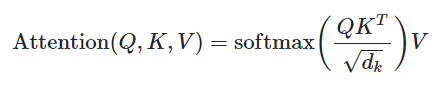

In [8]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim):
        super(ScaledDotProductAttention, self).__init__()
        self.dim = dim

    def forward(self, query, key, value):
        score = torch.bmm(query, key.transpose(1, 2)) / np.sqrt(self.dim) # batch matrix multiplication
        attn = F.softmax(score, dim=-1)
        output = torch.bmm(attn, value)
        return output, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.dim = hidden_dim // num_heads
        
        assert hidden_dim % self.num_heads == 0
        
        self.scaled_dot = ScaledDotProductAttention(self.dim)
        
        # WQ, WK, WV
        self.query_projection = nn.Linear(hidden_dim, self.hidden_dim)
        self.key_projection   = nn.Linear(hidden_dim, self.hidden_dim)
        self.value_projection = nn.Linear(hidden_dim, self.hidden_dim)
        
        # WO
        self.out_projection = nn.Linear(hidden_dim << 1, self.hidden_dim, bias=True)
        
    def split_heads(self, inputs, batch_size):
        inputs = inputs.view(batch_size, -1, self.num_heads, self.dim)
        return inputs.permute(2, 0, 1, 3).contiguous().view(batch_size * self.num_heads, -1, self.dim)

    def forward(self, query, value, prev_attn=None):
        batch_size = value.size(0)
        residual = query

        query = self.query_projection(query).view(batch_size, -1, self.num_heads, self.dim)
        key = self.key_projection(value).view(batch_size, -1, self.num_heads, self.dim)
        value = self.value_projection(value).view(batch_size, -1, self.num_heads, self.dim)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        context, attn = self.scaled_dot(query, key, value)
        context = context.view(self.num_heads, batch_size, -1, self.dim)
        
        context = context.permute(1, 2, 0, 3).contiguous().view(batch_size, -1, self.num_heads * self.dim)
        combined = torch.cat([context, residual], dim=2)

        output = torch.tanh(self.out_projection(combined.view(-1, self.hidden_dim << 1))).view(batch_size, -1, self.hidden_dim)
        
        return output, context

# Speller

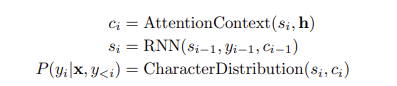

In [9]:
class Speller(nn.Module):
    def __init__(self, num_classes, hidden_dim, max_step=CFG.max_length, sos_token=1, eos_token=2, dropout=0.0, n_layers=2, num_heads=4):
        super(Speller, self).__init__()
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.num_heads = num_heads
        
        self.max_step = max_step
        self.eos_token = eos_token
        self.sos_token = sos_token
        
        self.emb = nn.Embedding(self.num_classes, self.hidden_dim)
        self.rnn = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.n_layers,
            bidirectional = False,
            dropout=dropout,
            batch_first=True
        )
        self.init_rnn_weights()
        self.attention = MultiHeadAttention(self.hidden_dim, self.num_heads)
        #self.attention = Attention(dec_dim=self.hidden_dim, enc_dim=self.hidden_dim, conv_dim=1, attn_dim=self.hidden_dim)
        self.character_distribution = nn.Linear(self.hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=-1)
    
    def init_rnn_weights(self, low=-0.1, high=0.1):
        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.uniform_(param.data, a=low, b=high)
            elif 'weight_hh' in name:
                torch.nn.init.uniform_(param.data, a=low, b=high)
            elif 'bias' in name:
                param.data.fill_(0)

    def init_hidden(self, batch_size):
        hidden = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        cell = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return (hidden.to(device),cell.to(device))
    
    def forward_step(self,inputs, hc, listener_features):
        decoder_output, hc = self.rnn(inputs, hc)
        att_out, context = self.attention(decoder_output,listener_features)
        #context = torch.sum(att_out, dim=1).unsqueeze(dim=1)
        #concat_output = torch.cat((decoder_output,context),dim=-1)
        logit = self.softmax(self.character_distribution(att_out))

        return logit, hc, context
    
    def forward(self, listener_features, ground_truth=None, teacher_forcing_rate = 0.9, use_beam=False, beam_size=3):
        if ground_truth is None:
            teacher_forcing_rate = 0
        teacher_forcing = True if np.random.random_sample() < teacher_forcing_rate else False
        
        if (ground_truth is None) and (not teacher_forcing):
            max_step = self.max_step
        else:
            max_step = ground_truth.size(1)
        
        input_word = torch.zeros(listener_features.size(0), 1).long().to(device)
        input_word[:,0] = self.sos_token
        
        init_context = torch.zeros_like(listener_features[:,0:1,:])
        inputs = self.emb(input_word)
        hc = self.init_hidden(input_word.size(0))
        logits = []
        
        if not use_beam:
            for step in range(max_step):
                logit, hc, context = self.forward_step(inputs, hc, listener_features)
                logits.append(logit.squeeze())
                if teacher_forcing:
                  output_word = ground_truth[:,step:step+1]
                else:
                  output_word = logit.topk(1)[1].squeeze(-1)
                inputs = self.emb(output_word)

            logits = torch.stack(logits, dim=1)
            #y_hats = torch.max(logits, dim=-1)[1]
            return logits
        else:
            btz = listener_features.size(0)
            y_hats = torch.zeros(btz, max_step).long().to(device)
            logit, hc, context = self.forward_step(inputs, hc, listener_features)
            output_words = logit.topk(beam_size)[1].squeeze(1)
            for bi in range(btz):
                b_output_words = output_words[bi,:].unsqueeze(0).transpose(1,0).contiguous()
                b_inputs = self.emb(b_output_words)
                b_listener_features = listener_features[bi,:,:].unsqueeze(0).expand((beam_size,-1,-1)).contiguous()
                if isinstance(hc, tuple):
                    b_h = hc[0][:,bi,:].unsqueeze(1).expand((-1,beam_size,-1)).contiguous()
                    b_c = hc[1][:,bi,:].unsqueeze(1).expand((-1,beam_size,-1)).contiguous()
                    b_hc = (b_h, b_c)
                else:
                    b_hc = hc[:,bi,:].unsqueeze(1).expand((-1,beam_size,-1)).contiguous()
                    
                scores = torch.zeros(beam_size,1).to(device)
                ids = torch.zeros(beam_size, max_step, 1).long().to(device)
                for step in range(max_step):
                    logit, b_hc, context = self.forward_step(b_inputs, b_hc, b_listener_features)
                    score, id = logit.topk(1)
                    scores += score.squeeze(1)
                    ids[:,step,:] = id.squeeze(1)
                    output_word = logit.topk(1)[1].squeeze(-1)
                    b_inputs = self.emb(output_word)
                y_hats[bi,:] = ids[scores.squeeze(1).topk(1)[1],:].squeeze(2)
            return y_hats

In [10]:
class LAS(nn.Module):
    def __init__(self, listener, speller):
        super(LAS, self).__init__()
        self.encoder = listener
        self.decoder = speller
        
    def forward(self, inputs, ground_truth=None, teacher_forcing_rate=0.9, use_beam=False, beam_size=16):
        listener_features, hidden = self.encoder(inputs)
        logits = self.decoder(listener_features, ground_truth, 
                              teacher_forcing_rate=teacher_forcing_rate, use_beam=use_beam, beam_size=beam_size)
        
        return logits

# SpecAugment
https://arxiv.org/pdf/1904.08779.pdf

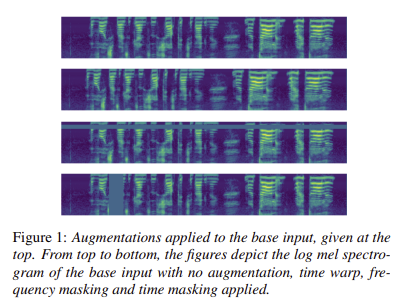

In [11]:
!pip install tensorflow_addons

In [12]:
import random
import numpy as np
import tensorflow as tf
from tensorflow_addons.image import sparse_image_warp
# reference: https://github.com/pyyush/SpecAugment
class SpecAugment():
    def __init__(self, policy, zero_mean_normalized=True):
        self.policy = policy
        self.zero_mean_normalized = zero_mean_normalized
        
        # Policy Specific Parameters
        if self.policy == 'LB':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 80, 27, 1, 100, 1.0, 1
        elif self.policy == 'LD':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 80, 27, 2, 100, 1.0, 2
        elif self.policy == 'SM':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 40, 15, 2, 70, 0.2, 2
        elif self.policy == 'SS':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 40, 27, 2, 70, 0.2, 2
    def timeWarping(self, feature):
        # Reshape to [Batch_size, time, freq, 1] for sparse_image_warp func.
        feature = np.reshape(feature, (-1, feature.shape[0], feature.shape[1], 1))
        
        v, tau = feature.shape[1], feature.shape[2]
        
        horiz_line_thru_ctr = feature[0][v//2]
    
        random_pt = horiz_line_thru_ctr[random.randrange(self.W, tau - self.W)] # random point along the horizontal/time axis
        w = np.random.uniform((-self.W), self.W) # distance
        
        # Source Points
        src_points = [[[v//2, random_pt[0]]]]
        
        # Destination Points
        dest_points = [[[v//2, random_pt[0] + w]]]
        
        feature, _ = sparse_image_warp(feature, src_points, dest_points, num_boundary_points=2)
    
        return feature
    
    def timeMasking(self, feature):
        tau = feature.shape[2] # time frames
        
        # apply m_T time masks to the mel spectrogram
        for i in range(self.m_T):
            t = int(np.random.uniform(0, self.T)) # [0, T)
            upper = tau if t>tau else t#make limitation
            t0 = random.randint(0, tau - upper) # [0, tau - t)
            feature[:, :, t0:t0 + t] = 0
            
        return feature

    def freqMasking(self, feature):
        size = feature.shape[1]
        
        for i in range(self.m_F):
            f = int(np.random.uniform(0, self.F)) # [0, F)
            f0 = random.randint(0, size - f) # [0, v - f)
            feature[:, f0:f0 + f] = 0
            
        return feature

In [13]:
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
from torchaudio import transforms, functional
import torch.nn.functional as F
import random

class SpeechDataset(Dataset):

    def __init__(self, char2id, split=CFG.dataset_list[4], max_len=0, augmentation=False, pkwargs=None):
        
        super(SpeechDataset, self).__init__()
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.char2id = char2id
        self.max_len = max_len
        self.augmentation = augmentation
        self.specAugment = SpecAugment('LB')
        self.pkwargs = pkwargs
        self.current = None
        
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=CFG.sr, n_fft=CFG.n_fft, hop_length=CFG.hop_length, n_mels=CFG.n_mels)
        self.db_converter = torchaudio.transforms.AmplitudeToDB()
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio, sample_rate, label, _, _, _ = self.dataset[idx]
        x = self.db_converter(self.mel_converter(audio))

        if self.augmentation:
            rand = random.randint(1, 10)
            if rand > 3:
                x = self.specAugment.freqMasking(x)
                if rand < 7:
                    x = self.specAugment.timeMasking(x)
            else:
                x = self.specAugment.timeMasking(x)
                
        self.current = {"input":x, "label":label}
        
        x = x[0,:,:].squeeze(1).t()
        if self.max_len:
            x = np.pad(x, ((0, 0), (0, self.max_len - x.shape[1])), "constant")
            
        y = []
        y.append(SOS_TOKEN)
        for char in label:
            try:
                y.append(self.char2id[char])
            except:
                y.append(self.char2id['<unk>'])
        y.append(EOS_TOKEN)
        y = np.array(y)
        return (x, y)
    
    def checkLogMelSpec(self, itemIndex):
        self.__getitem__(itemIndex)
        print(self.current['input'].shape)
        self.plot_spectrogram(self.current['input'][0], title="LogMelSpectrogram", ylabel="mel freq")
        print(self.current['label'])
        
    def plot_spectrogram(self, specgram, title=None, ylabel="freq_bin"):
        fig, axs = plt.subplots(1, 1, figsize=(10, 4))
        axs.set_title(title or "Spectrogram")
        axs.set_ylabel(ylabel)
        axs.set_xlabel("frame")
        im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
        fig.colorbar(im, ax=axs)
        plt.show(block=False)

In [14]:
def _collate_fn(batch):
    """ functions that pad to the maximum sequence length """
    def seq_length_(p):
        return len(p[0])

    def target_length_(p):
        return len(p[1])

    seq_lengths = [len(s[0]) for s in batch]
    target_lengths = [len(s[1]) for s in batch]

    max_seq_sample = max(batch, key=seq_length_)[0]
    max_target_sample = max(batch, key=target_length_)[1]

    max_seq_size = max_seq_sample.size(0)
    max_target_size = len(max_target_sample)

    feat_size = max_seq_sample.size(1)
    batch_size = len(batch)

    seqs = torch.zeros(batch_size, max_seq_size, feat_size)

    targets = torch.zeros(batch_size, max_target_size).to(torch.long)
    targets.fill_(0)

    for x in range(batch_size):
        sample = batch[x]
        tensor = sample[0]
        target = sample[1]
        seq_length = tensor.size(0)
        seqs[x].narrow(0, 0, seq_length).copy_(tensor)
        targets[x].narrow(0, 0, len(target)).copy_(torch.LongTensor(target))
    return seqs, targets

In [15]:
train_dataset = SpeechDataset(char2id, split=CFG.dataset_list[4], max_len=0)
generated_dataset = SpeechDataset(char2id, split=CFG.dataset_list[0], augmentation=True, max_len=0)
test_dataset = SpeechDataset(char2id, split="test-clean", max_len=0)
augmented_dataset = torch.utils.data.ConcatDataset([train_dataset, generated_dataset])

  0%|          | 0.00/5.95G [00:00<?, ?B/s]

  0%|          | 0.00/322M [00:00<?, ?B/s]

  0%|          | 0.00/331M [00:00<?, ?B/s]

torch.Size([1, 100, 176])


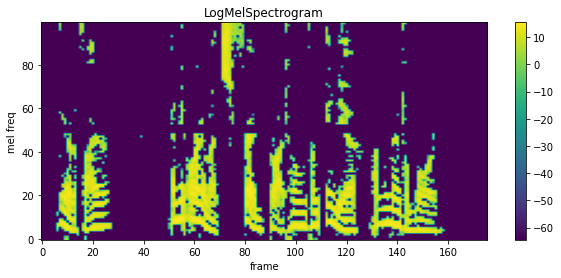

NEAR THE FIRE AND THE ORNAMENTS FRED BROUGHT HOME FROM INDIA ON THE MANTEL BOARD


In [16]:
generated_dataset.checkLogMelSpec(10)

In [17]:
train_dataloader = DataLoader(augmented_dataset, batch_size=CFG.batch_size, shuffle=True, pin_memory=True,
                              collate_fn=_collate_fn, num_workers=CFG.worker)
test_dataloader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=True, pin_memory=True,
                             collate_fn=_collate_fn, num_workers=CFG.worker)

In [18]:
def label_to_string(labels, id2char):
    """
    Converts label to string (number => Hangeul)

    Args:
        labels (list): number label
        id2char (dict): id2char[id] = ch
        eos_id (int): identification of <end of sequence>

    Returns: sentence
        - **sentence** (str or list): Hangeul representation of labels
    """
    sos_id = char2id['<sos>']
    eos_id = char2id['<eos>']
    if len(labels.shape) == 1:
        sentence = str()
        for label in labels:
            if label.item() == sos_id:
                continue
            if label.item() == eos_id:
                break
            sentence += id2char[label.item()]
        return sentence

    elif len(labels.shape) == 2:
        sentences = list()
        for batch in labels:
            sentence = str()
            for label in batch:
                if label.item() == sos_id:
                    continue
                if label.item() == eos_id:
                    break
                sentence += id2char[label.item()]
            sentences.append(sentence)
        return sentences

In [19]:
import torch.optim as optim
listener = Listener(CFG.num_channels, 256)
speller = Speller(len(id2char), 512, num_heads=4, dropout=0.3)
model = LAS(listener, speller).to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index = PAD_TOKEN).to(device)

# Check Modules works well

In [20]:
inputs, classes = next(iter(train_dataloader))

In [21]:
print(inputs.shape)

torch.Size([4, 500, 100])


In [22]:
feat, hid = listener(inputs.to(device))
print(feat.shape)
print(hid[0].shape)
print(hid[1].shape)

torch.Size([4, 63, 512])
torch.Size([2, 4, 256])
torch.Size([2, 4, 256])


In [23]:
logi = speller(feat, classes.to(device),teacher_forcing_rate=0.99, use_beam=False, beam_size=3)
print(logi.shape)

torch.Size([4, 275, 32])


In [24]:
result = model(inputs.to(device), ground_truth=classes.to(device), teacher_forcing_rate=0.99)
result

tensor([[[-3.4314, -3.4565, -3.4827,  ..., -3.4914, -3.4960, -3.4441],
         [-3.4300, -3.4452, -3.5128,  ..., -3.5060, -3.5058, -3.4398],
         [-3.4282, -3.4511, -3.5503,  ..., -3.4891, -3.4948, -3.4265],
         ...,
         [-3.4348, -3.4498, -3.5079,  ..., -3.4330, -3.4271, -3.4999],
         [-3.4195, -3.4206, -3.5068,  ..., -3.4367, -3.4050, -3.5054],
         [-3.3989, -3.4446, -3.5100,  ..., -3.4434, -3.4028, -3.5091]],

        [[-3.4317, -3.4730, -3.4843,  ..., -3.4727, -3.4837, -3.4584],
         [-3.4440, -3.4656, -3.4757,  ..., -3.4824, -3.4883, -3.4620],
         [-3.4267, -3.4577, -3.5239,  ..., -3.4732, -3.5069, -3.4478],
         ...,
         [-3.4097, -3.4455, -3.4933,  ..., -3.4613, -3.3798, -3.4924],
         [-3.3771, -3.4610, -3.4927,  ..., -3.4319, -3.3769, -3.4904],
         [-3.4064, -3.4528, -3.4931,  ..., -3.4314, -3.3942, -3.5148]],

        [[-3.4432, -3.4532, -3.4791,  ..., -3.4586, -3.4873, -3.4773],
         [-3.4187, -3.4785, -3.4885,  ..., -3

In [25]:
if result.dim() == 2:
    result = result.T
    result = result.unsqueeze(0)

In [26]:
logi.view([logi.size(0), -1, logi.size(-2)])[0][0]

tensor([-3.4400, -3.4644, -3.4816, -3.4449, -3.4900, -3.4039, -3.4357, -3.5312,
        -3.4201, -3.5459, -3.5422, -3.5120, -3.4474, -3.4458, -3.4360, -3.4155,
        -3.4387, -3.4633, -3.4583, -3.4960, -3.4462, -3.4507, -3.4234, -3.5024,
        -3.4148, -3.4850, -3.4664, -3.4992, -3.4955, -3.4894, -3.4843, -3.4545,
        -3.4037, -3.4658, -3.4996, -3.4350, -3.5005, -3.3852, -3.4232, -3.5206,
        -3.4371, -3.5326, -3.5618, -3.5173, -3.4542, -3.4408, -3.4815, -3.4160,
        -3.4478, -3.4722, -3.4378, -3.4913, -3.4258, -3.4503, -3.4087, -3.5030,
        -3.4151, -3.5039, -3.4663, -3.5046, -3.5125, -3.4786, -3.4985, -3.4407,
        -3.4270, -3.4649, -3.5456, -3.4234, -3.5103, -3.3967, -3.4374, -3.5484,
        -3.4420, -3.5257, -3.5581, -3.4892, -3.4556, -3.4223, -3.4761, -3.4096,
        -3.4191, -3.4883, -3.4200, -3.5237, -3.4168, -3.4338, -3.4388, -3.5266,
        -3.4193, -3.5142, -3.4594, -3.4731, -3.5041, -3.4554, -3.4865, -3.4255,
        -3.4363, -3.4877, -3.5553, -3.36

In [27]:
print(classes.shape)
print(classes)

torch.Size([4, 275])
tensor([[ 1, 13, 24,  ...,  0,  0,  0],
        [ 1, 13, 24,  ...,  0,  0,  0],
        [ 1, 24, 12,  ...,  0,  0,  0],
        [ 1,  6, 25,  ..., 10,  9,  2]])


In [28]:
print(logi.view(-1, logi.size(-1)).shape)

torch.Size([1100, 32])


In [29]:
print(classes.view(-1).shape)

torch.Size([1100])


In [30]:
print(logi.view(-1, logi.size(-1)).shape)
print(classes.shape)
loss = criterion(logi.view(-1, logi.size(-1)), classes.view(-1).to(device))
loss

torch.Size([1100, 32])
torch.Size([4, 275])


tensor(3.4700, device='cuda:0', grad_fn=<AddBackward0>)

# Train & Evaluate

In [31]:
def last_checkpoint(path, epoch, model, optimizer, loss):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path+'/last_checkpoint.pt')
    
def score(pred, y):
    cer = 0.
    wer = 0.
    pred_sts = label_to_string(pred, id2char)
    gold_sts = label_to_string(y, id2char)
    for i, (res,gt) in enumerate(zip(pred_sts,gold_sts)):
        cer += torchmetrics.functional.char_error_rate(res,gt)
        wer += torchmetrics.functional.word_error_rate(res,gt)
    return cer, wer

In [32]:
def scheduler_sampling(epoch, e_min=1, ratio_s=0.9, ratio_e=0, n_epoch_ramp=10):
    if epoch>e_min:
        epoch -= e_min
        teacher_forcing_ratio = max(ratio_s - (ratio_s-ratio_e)*epoch/n_epoch_ramp, ratio_e)
    else:
        teacher_forcing_ratio = 0.9
    return teacher_forcing_ratio

In [33]:
def set_lr(optimizer, lr):
        for g in optimizer.param_groups:
            g['lr'] = lr

In [34]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
#scheduler = ReduceLROnPlateau(optimizer, 'min')

epochs = 2
checkpoint = 1
print_step = 200
save_epoch = 1
checkpoint_path = './'

loss_history =[]
for epoch in range(epochs):
    total_loss = 0.
    num_samples = 0
    cer = 0.
    wer = 0.
    step= 0
    if epoch==5:
        set_lr(optimizer, 1e-5)
    total_step = len(train_dataloader)
    for batch in train_dataloader:
        model.train()
        optimizer.zero_grad()

        x, y = batch
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        target = y[:, :].contiguous().to(device)
        teacher_forcing_rate = scheduler_sampling(epoch)
        
        logits = model(x, ground_truth=y, teacher_forcing_rate=teacher_forcing_rate)
        
        if logits.dim() == 2:
            logits = logits.T
            logits = logits.unsqueeze(0)
            
        y_hats = torch.max(logits, dim=-1)[1]
        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

        total_loss += loss.item()
        num_samples += batch_size

        loss.backward()
        loss_history.append(loss.item())
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=400)
        optimizer.step()
        
        cer_, wer_ = score(y_hats.long(), target)
        cer += cer_
        wer += wer_
        if step%print_step==0:
            print('timestep: {:4d}/{:4d}, loss: {:.4f}, cer: {:.2f}, wer: {:.2f}, tf_rate: {:.2f}'.format(
                step, total_step, total_loss/num_samples, cer/num_samples, wer/num_samples, teacher_forcing_rate))
            with open('aihub-4.log', 'at') as f:
                f.write('timestep: {:4d}/{:4d}, loss: {:.4f}, cer: {:.2f}, wer: {:.2f}, tf_rate: {:.2f}\n'.format(
                step, total_step, total_loss/num_samples, cer/num_samples, wer/num_samples, teacher_forcing_rate))
        step += 1
        
    total_loss /= num_samples
    cer /= num_samples
    wer /= num_samples
    print('Epoch %d (Training) Total Loss %0.4f CER %0.4f WER %0.4f' % (epoch, total_loss, cer, wer))
    with open('las.log', 'at') as f:
        f.write('Epoch %d (Training) Total Loss %0.4f CER %0.4f WER %0.4f\n' % (epoch, total_loss, cer, wer))

    total_loss = 0.
    num_samples = 0
    cer = 0.
    wer = 0.
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_dataloader):
            x, y = batch

            batch_size = x.size(0)
            
            x = x.to(device)
            y = y.to(device)
            target = y[:, :].contiguous().to(device)
            
            logits = model(x, ground_truth=None, teacher_forcing_rate=0.0)
            if logits.dim() == 2:
                logits = logits.T
                logits = logits.unsqueeze(0)
            y_hats = torch.max(logits, dim=-1)[1]
            
            logits = logits[:,:target.size(1),:].contiguous() # cut over length to calculate loss
            target = target[:,:logits.size(1)].contiguous()

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

            total_loss += loss.item()

            cer_, wer_ = score(y_hats.long(), target)
            cer += cer_
            wer += wer_
            num_samples += batch_size

    val_loss = total_loss/num_samples
    
    #scheduler.step(val_loss)
    val_loss = total_loss/num_samples
    cer /= num_samples
    wer /= num_samples
    #scheduler.step(val_loss)
    print('Epoch %d (Evaluate) Total Loss %0.4f CER %0.4f WER %0.4f' % (epoch, val_loss, cer, wer))
    with open('las.log', 'at') as f:
        f.write('Epoch %d (Evaluate) Total Loss %0.4f CER %0.4f WER %0.4f\n' % (epoch, val_loss, cer, wer))
    last_checkpoint(checkpoint_path+'/', epoch, model, optimizer, loss)
    if epoch%save_epoch==0:
        torch.save(model, "{}/epoch{}-cer{:.2f}-wer{:.2f}.pt".format(checkpoint_path, epoch, cer, wer))

timestep:    0/7811, loss: 0.8677, cer: 1.11, wer: 1.00, tf_rate: 0.90
timestep:  200/7811, loss: 0.6449, cer: 1.00, wer: 1.27, tf_rate: 0.90
timestep:  400/7811, loss: 0.6068, cer: 0.85, wer: 1.23, tf_rate: 0.90
timestep:  600/7811, loss: 0.5876, cer: 0.81, wer: 1.19, tf_rate: 0.90
timestep:  800/7811, loss: 0.5754, cer: 0.81, wer: 1.16, tf_rate: 0.90
timestep: 1000/7811, loss: 0.5674, cer: 0.82, wer: 1.14, tf_rate: 0.90
timestep: 1200/7811, loss: 0.5604, cer: 0.81, wer: 1.13, tf_rate: 0.90
timestep: 1400/7811, loss: 0.5541, cer: 0.80, wer: 1.12, tf_rate: 0.90
timestep: 1600/7811, loss: 0.5493, cer: 0.80, wer: 1.11, tf_rate: 0.90
timestep: 1800/7811, loss: 0.5451, cer: 0.80, wer: 1.11, tf_rate: 0.90
timestep: 2000/7811, loss: 0.5402, cer: 0.79, wer: 1.11, tf_rate: 0.90
timestep: 2200/7811, loss: 0.5375, cer: 0.80, wer: 1.10, tf_rate: 0.90
timestep: 2400/7811, loss: 0.5345, cer: 0.80, wer: 1.10, tf_rate: 0.90
timestep: 2600/7811, loss: 0.5317, cer: 0.80, wer: 1.11, tf_rate: 0.90
timest

100%|██████████| 655/655 [06:46<00:00,  1.61it/s]


Epoch 0 (Evaluate) Total Loss 0.7535 CER 7.5047 WER 0.9501
timestep:    0/7811, loss: 0.7534, cer: 1.30, wer: 0.93, tf_rate: 0.90
timestep:  200/7811, loss: 0.4693, cer: 1.13, wer: 1.02, tf_rate: 0.90
timestep:  400/7811, loss: 0.4659, cer: 1.05, wer: 1.02, tf_rate: 0.90
timestep:  600/7811, loss: 0.4668, cer: 0.99, wer: 1.02, tf_rate: 0.90
timestep:  800/7811, loss: 0.4665, cer: 0.94, wer: 1.02, tf_rate: 0.90
timestep: 1000/7811, loss: 0.4673, cer: 0.93, wer: 1.02, tf_rate: 0.90
timestep: 1200/7811, loss: 0.4667, cer: 0.93, wer: 1.02, tf_rate: 0.90
timestep: 1400/7811, loss: 0.4664, cer: 0.94, wer: 1.03, tf_rate: 0.90
timestep: 1600/7811, loss: 0.4669, cer: 0.93, wer: 1.04, tf_rate: 0.90
timestep: 1800/7811, loss: 0.4663, cer: 0.96, wer: 1.04, tf_rate: 0.90
timestep: 2000/7811, loss: 0.4663, cer: 0.96, wer: 1.04, tf_rate: 0.90
timestep: 2200/7811, loss: 0.4656, cer: 0.96, wer: 1.05, tf_rate: 0.90
timestep: 2400/7811, loss: 0.4662, cer: 0.96, wer: 1.05, tf_rate: 0.90
timestep: 2600/781

100%|██████████| 655/655 [06:31<00:00,  1.67it/s]


Epoch 1 (Evaluate) Total Loss 0.7554 CER 4.5210 WER 1.0333


# Test model performance
## Please, pay attention with "model(input_data.cuda(), ground_truth=ans_data, teacher_forcing_rate=0.5)"
## Cause of long trainging time, i just train with few epochs in this notebook. So I need to few teacher forcing for check performance. thanks!

In [35]:
with torch.no_grad():
    input_data, ans_data = next(iter(train_dataloader))
    ans_data = ans_data.to(device)
    print(input_data.shape)
    print(ans_data.shape)
    print(label_to_string(ans_data, id2char))
    
    result_logit = model(input_data.to(device), ground_truth=ans_data, teacher_forcing_rate=0.5)

    result_logit = result_logit[:,:ans_data.size(1),:].contiguous()
    ans_data = ans_data[:,:result_logit.size(1)].contiguous()

    loss_check = criterion(result_logit.view(-1, result_logit.size(-1)), ans_data.view(-1))
    print(loss_check)
    y_pred = torch.max(result_logit, dim=-1)[1]
    print(label_to_string(y_pred, id2char))

torch.Size([4, 506, 100])
torch.Size([4, 233])
['THIS QUANTITY IS THE SAME FOR ALL OF US THIS IDENTITY OF CONCESSION WHICH EACH MAKES TO ALL IS CALLED EQUALITY COMMON RIGHT IS NOTHING ELSE THAN THE PROTECTION OF ALL BEAMING ON THE RIGHT OF EACH', "AND ANYWAY I'M THANKFUL TO HAVE JULIA TAKE A FANCY TO ANYBODY IT LEAVES US A GREAT DEAL FREER TO DO AS WE LIKE I SHOULD THINK THAT YOU WOULD SEE THAT YOURSELF OH WELL SAID NORA LAUGHING THE WHOLE THING IS NOT WORTH QUARRELING ABOUT", 'NOTICED AN ATTENDANT WALK ACROSS THE ROOM HE IDENTIFIED THE MOVEMENT WITH THAT OF HIS OWN HE DID NOT YET DISCRIMINATE BETWEEN HIS OWN MOVEMENTS AND THOSE OUTSIDE HIMSELF', 'AND WE ATTACH OUR SIGNATURES THE SHERIFF INTERRUPTED SAYING HERE ARE THE SIGNATURES ALL IN DIFFERENT HANDWRITINGS AND HE RESUMED']
tensor(1.6315, device='cuda:0')
['AHES SUERTITY ON THE STME TIRMT L TF TS THES WSEATICY OF TOUSERSION TAICH WVCH OANES TH T L TT TOLLED TVUAL TY TONEAN AEGHT AN AOT ING TVSE THET THE SRIFECTION OF T L TEIUING TN T

In [36]:
with torch.no_grad():
    input_data, ans_data = next(iter(train_dataloader))
    ans_data = ans_data.to(device)
    print(input_data.shape)
    print(ans_data.shape)
    print(label_to_string(ans_data, id2char))
    
    result_logit = model(input_data.to(device), ground_truth=ans_data, teacher_forcing_rate=0.9)

    result_logit = result_logit[:,:ans_data.size(1),:].contiguous()
    ans_data = ans_data[:,:result_logit.size(1)].contiguous()

    loss_check = criterion(result_logit.view(-1, result_logit.size(-1)), ans_data.view(-1))
    print(loss_check)
    y_pred = torch.max(result_logit, dim=-1)[1]
    print(label_to_string(y_pred, id2char))

torch.Size([4, 497, 100])
torch.Size([4, 272])
['BUT I COULD NOT HELP FEELING THAT ON THIS DAY OF DAYS EVEN A GRIZZLY FELT MISPLACED AND COMMON SURE ENOUGH AN UNDENIABLE BEAR SPRANG OUT ON US AS WE DROPPED INTO THE ROAD THEN ENSUED SHRIEKS GROWLINGS REVOLVER SHOTS AND UNRECORDED HEROISMS', 'NO POLICY IS ATTEMPTED UNTIL IT IS ASCERTAINED THAT THE NEWSPAPER OWNER IS IN FAVOUR OF IT FEW ARE PROFFERED WITHOUT FIRST CONSULTING HIS WISHES MANY ARE DIRECTLY ORDERED BY HIM WE ARE IF WE TALK IN TERMS OF REAL THINGS AS MEN DO IN THEIR PRIVATE COUNCILS AT WESTMINSTER', 'WITH MARK BEFORE THE LATTER COULD STRIKE A BLOW GRAPPLED WITH HIM AND HELD HIM FAST TILL HE WAS SECURED AND HIS ARMS TIED BEHIND HIM AND SO IT IS YOU MORGAN FENWOLF', 'IN THE HOLY SUTRAS IT IS WRITTEN THAT THOSE STRONGEST IN WRONG DOING CAN BECOME BY POWER OF GOOD RESOLVE THE STRONGEST IN RIGHT DOING I DO NOT DOUBT THAT YOU HAVE A GOOD HEART AND I HOPE THAT BETTER FORTUNE WILL COME TO YOU']
tensor(1.7461, device='cuda:0')
['TUT IT

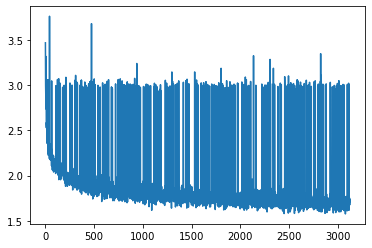

In [37]:
plt.plot(loss_history[::5])

* version 1: LAS model with label smoothing, teacher forcing
* version 2: specAugment is added(time warping, time msking, frequency masking)
* &nbsp;&nbsp;&nbsp; version 2.0.1: fix random seed & cuda() => to.(device)

Reference: https://github.com/qute012/las-ko/blob/master/aihub.ipynb